# Projet MP06

## Code FreeFem+

In [1]:
file = open('ProjetMP06_FreeFem.edp', 'r')
file_content = file.read()
print(file_content)


//cas 1 : Convex

real l=450;

// Design variables

// include the getARGV function to read values of arguments specified on command line
include "getARGV.idp";

// real h0=100;
// real h1=50;
// real r0=30;
// real r1=20;

real h0=getARGV("h0",100);
real h1=getARGV("h1",50);
real r0=getARGV("r0",30);
real r1=getARGV("r1",20);

//centre et rayon du premier cercle

real xc1 = 0;
real yc1 = ((h0*h0/4)-(l*l)-(h1*h1/4))/(h0-h1);
real R = (h0/2)-yc1;
// cout << "yc1=" << yc1 << endl;
// cout << "R=" << R << "\n";

//centre du deuxiÃ¨me cercle 
real xc2 = 0;
real yc2 = R-h0/2;
// cout << "yc2=" << yc2 << endl;
// cout << "R=" << R << "\n";

// calcul de l'angle des cercles (TrigonomÃ©trie)
real alpha=asin(l/R);
// cout << "alpha=" << alpha << endl;



border a(t=-h0/2,h0/2){x=0;y=t;label=1;};
border b(t=0,alpha){x=xc1+R*sin(t);y=yc1+R*cos(t);label= 2;};
border c(t=h1/2,-h1/2){x=l ;y=t ;label=3 ;};
border d(t=alpha,0){x=xc2+R*sin(t);y=yc2+R*cos(t+pi);label=4;};
border e(t=0,2*pi){x=(l/5)+r0*

## Utilisation de FreeFem+

![](convex-21-mesh.eps)

In [2]:
!FreeFem++ -nw -v 0 ProjetMP06_FreeFem.edp h0 100 h1 50 r0 30 r1 20


Max von Mises Stress 186.746
Max displacement 0.820682
Area             33435.8


## Resultats dans le notebook

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 'magic command' to modify the output format of the image 'svg' -> vectorized format (better quality)
%config InlineBackend.figure_format = 'svg'
# Read the image file :
img1 = mpimg.imread('convex-2D-mesh.eps')
img2 = mpimg.imread('convex-2D-meshdef.eps')
img3 = mpimg.imread('convex-2D-sigvm.eps')
# Create a figure (to specify the size)
plt.figure(figsize=(15,5))
# Display the image :
plt.imshow(img1,interpolation='antialiased')
plt.figure(figsize=(15,5))
plt.imshow(img2,interpolation='antialiased')
plt.figure(figsize=(15,5))
plt.imshow(img3,interpolation='antialiased')

## Utilisation de FreeFem++ dans le notebook

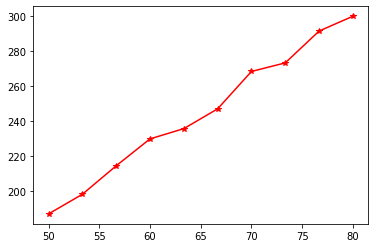

In [3]:
import run_freefem as rf        # Importation of module run_freefem, named 'rf'
import numpy as np              # Numpy for array
import matplotlib.pyplot as plt # pyplot from matplotlib to plot graphics.

# 10 valeurs de h1 :
h1_val = np.linspace(50,80,10)

sigmax = []

for h1 in h1_val:

    input_value = {'h0':100,'h1':h1,'r0':30,'r1':20}
    Out = rf.run_freefem('ProjetMP06_FreeFem.edp',input_value)

    sigmax.append(Out[0][0])


plt.plot(h1_val,sigmax,'r*-')

## Optimisation

In [ ]:
# Importation des Bibliothèques
import numpy as np
import math as m

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
%config InlineBackend.figure_format = 'svg'

import run_freefem as rf

from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds

# Valeures donnees
Re = 350.0 #MPa
U_max = 1.5 #mm
l = 450 #mm

# Objectif
def Air_Obj(x):
    
    h0 = x[0]
    h1 = x[1]
    r0 = x[2]
    r1 = x[3]
    input_value = {'h0':h0,'h1':h1,'r0':r0,'r1':r1}
    Out = rf.run_freefem('ProjetMP06_FreeFem.edp',input_value)
    
    Air = Out[0][2]
    
    return Air

#Definitions des Contraintes
def convex_cnt(x):
    
    h0 = x[0]
    h1 = x[1]
    r0 = x[2]
    r1 = x[3]
    input_value = {'h0':h0,'h1':h1,'r0':r0,'r1':r1}
    Out = rf.run_freefem('ProjetMP06_FreeFem.edp',input_value)
    
    # Contraintre des rayons intérieurs

    R = (h0/2)-((h0*h0/4)-(l*l)-(h1*h1/4))/(h0-h1)
    
    rx_max = l/5
    r0y_max = ((h0*h0/4)-(l*l)-(h1*h1/4))/(h0-h1) - m.sqrt(-((l/5)**2)+(R**2))
    r1y_max = ((h0*h0/4)-(l*l)-(h1*h1/4))/(h0-h1) - m.sqrt(-((4*l/5)**2)+(R**2))

    # Contrainte maximale 
    Sigmax = Out[0][0]
    
    # Deplacement en bout de poutre :
    D_max = Out[0][1]
    
    #Epaisseur minimal entre les deux cercles :
    Epmin = 10
    
    # Contraintes :
    Cnt = np.array([Sigmax/Re - 1,
                    D_max/U_max - 1,
                    r0/rx_max - 1,
                    r0/(r0y_max) - 1,
                    r1/rx_max - 1,
                    r1/(r1y_max) - 1,
                    h0/h1 - 1,
                    (r0-r1)/Epmin - 1])
    return  Cnt

# Bornes de l'espace de recherche de la solution              
convex_bounds = Bounds([30,20,10,5],
                       [200,180,60,60])                    
                    
# Contraintes du problème d'optimisation :                    
nonlinear_constraint = NonlinearConstraint(convex_cnt,-np.inf,0)
                    
# Fonction pour stocker les infos des itérations de l'algorithme
# d'optimisation.                    
def reporter(p,opt_res):

    global ps,fs,cs
    ps.append(p)
    fs.append(opt_res.fun)
    cs.append(opt_res.constr_violation)
    return

# Point de départ choisi arbritrairement.                   
x0 = np.array([85,80,25,27.5])
ps = [x0]
fs = [0]
cs = [0] 
       
# Calculs d'optimisation
# Méthode "trust-constraint"
res = minimize(Air_Obj, x0,
               method='trust-constr',
               constraints=[nonlinear_constraint],
               options={'disp':1,'verbose':3},
               bounds=convex_bounds,
               callback=reporter)

# Affiche la solution :
print('\n\nSolution optimale :\nd0=%6.2fmm d1=%6.2fmm'%(res.x[0],res.x[1],res.x[2],res.x[3]))

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   5   |   0   | +3.3258e+04 | 1.00e+00 | 5.15e-03 | 1.78e-01 | 1.00e+00 |  1.00e-01   |   0   |


C:\Users\Geapi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   2   |  10   |   1   | +3.3111e+04 | 5.60e+00 | 5.62e-03 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   3   |  15   |   2   | +3.3111e+04 | 6.42e+00 | 6.22e-03 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |  20   |   3   | +3.3111e+04 | 6.42e+00 | 6.60e-03 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |  25   |   4   | +3.3111e+04 | 6.42e+00 | 7.52e-03 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   6   |  30   |   5   | +3.3111e+04 | 6.42e+00 | 9.15e-03 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |  35   |   6   | +3.3111e+04 | 6.42e+00 | 1.03e-02 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  40   |   7   | +3.3111e+04 | 6.42e+00 | 1.10e-02 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|   9   |  45   |   8   | +3.3111e+04 | 6.42e+00 | 1.13e-02 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|  10   |  50   |   9   | +3.3111e+04 | 6.42e+00 | 1.15e-02 | 2.03e-01 | 1.00e+00 |  1.00e-01   |   4   |
|  11   |  55   |  10   | +3.3111e+04 | 6.42e+

C:\Users\Geapi\anaconda3\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


|  52   |  260  |  51   | +3.3111e+04 | 6.42e+00 | 1.06e-02 | 2.03e-01 | 4.26e+01 |  1.00e-01   |   4   |
|  53   |  265  |  53   | +3.3111e+04 | 7.93e+00 | 1.28e-02 | 2.03e-01 | 4.26e+01 |  1.00e-01   |   4   |
|  54   |  270  |  54   | +3.3111e+04 | 7.93e+00 | 1.28e-02 | 2.03e-01 | 6.10e+01 |  1.00e-01   |   4   |
